<a href="https://colab.research.google.com/github/gpicciuca/ai_engineering_master/blob/main/module4_ml_models_algos/Project_Exotic_Fruits_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Exotic fruits classification using KNN
Module 4: Machine Learning models and algorithms<br>
Master in AI Engineering @ profession.ai

## Requirements
1. Prepare the dataset: Load, explore, preprocess, clean and scale the data
2. KNN Model: Implement the model and optimize for best prediction accuracy
3. Performance evaluation: Cross-validation to validate generalization and metrics
4. Visual presentation of results



In [278]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, root_mean_squared_error, confusion_matrix

In [279]:
RNG_SEED = 0 # For reproducable results

In [280]:
DS_URL = "https://proai-datasets.s3.eu-west-3.amazonaws.com/fruits.csv"

df = pd.read_csv(DS_URL)
df.head()

Frutto  Peso (g)  Diametro medio (mm)  Lunghezza media (mm)  \
0   Mela     86.40                89.68                  8.69   
1   Mela     77.58                73.45                  6.49   
2   Mela     81.95                81.66                  6.40   
3   Mela     66.33                36.71                  6.78   
4   Mela     56.73                75.69                  5.78   

   Durezza buccia (1-10)  Dolcezza (1-10)  
0                   9.61             2.41  
1                   7.20             3.87  
2                   9.09             2.88  
3                   8.21             2.55  
4                   9.15             3.88

The project assignment specifies an additional feature (acidity) which is missing from the dataset. However, we can calculate it as the inverse of the sweetness.

In [281]:
df["Acidità (1-10)"] = 10.0 - df["Dolcezza (1-10)"]
df.head()

Frutto  Peso (g)  Diametro medio (mm)  Lunghezza media (mm)  \
0   Mela     86.40                89.68                  8.69   
1   Mela     77.58                73.45                  6.49   
2   Mela     81.95                81.66                  6.40   
3   Mela     66.33                36.71                  6.78   
4   Mela     56.73                75.69                  5.78   

   Durezza buccia (1-10)  Dolcezza (1-10)  Acidità (1-10)  
0                   9.61             2.41            7.59  
1                   7.20             3.87            6.13  
2                   9.09             2.88            7.12  
3                   8.21             2.55            7.45  
4                   9.15             3.88            6.12

Prior to the data exploration, it'd be a good choice to encode the target classes into something numerical. This will help both the data visualization and also the model training later on.<br>
Since the target classes don't seem to have a particular ordner, we can try either the LabelEncoder or the OneHotEncoder.<br><br>
LabelEncoder should be sufficient for this case.

In [282]:
target_classes = df["Frutto"].unique()

label_enc = LabelEncoder()
df["Frutto"] = label_enc.fit_transform(df["Frutto"])

target_classes_dict = np.array(sorted(zip(df["Frutto"].unique(), target_classes), key=lambda x: x[0]))
print(target_classes_dict)

df.head()

[['0' 'Arancia']
 ['1' 'Banana']
 ['2' 'Kiwi']
 ['3' 'Mela']
 ['4' 'Uva']]


Frutto  Peso (g)  Diametro medio (mm)  Lunghezza media (mm)  \
0       3     86.40                89.68                  8.69   
1       3     77.58                73.45                  6.49   
2       3     81.95                81.66                  6.40   
3       3     66.33                36.71                  6.78   
4       3     56.73                75.69                  5.78   

   Durezza buccia (1-10)  Dolcezza (1-10)  Acidità (1-10)  
0                   9.61             2.41            7.59  
1                   7.20             3.87            6.13  
2                   9.09             2.88            7.12  
3                   8.21             2.55            7.45  
4                   9.15             3.88            6.12

# Data exploration
Understanding the data we're working with will potentially uncover hidden patterns, noise, correlation, etc.

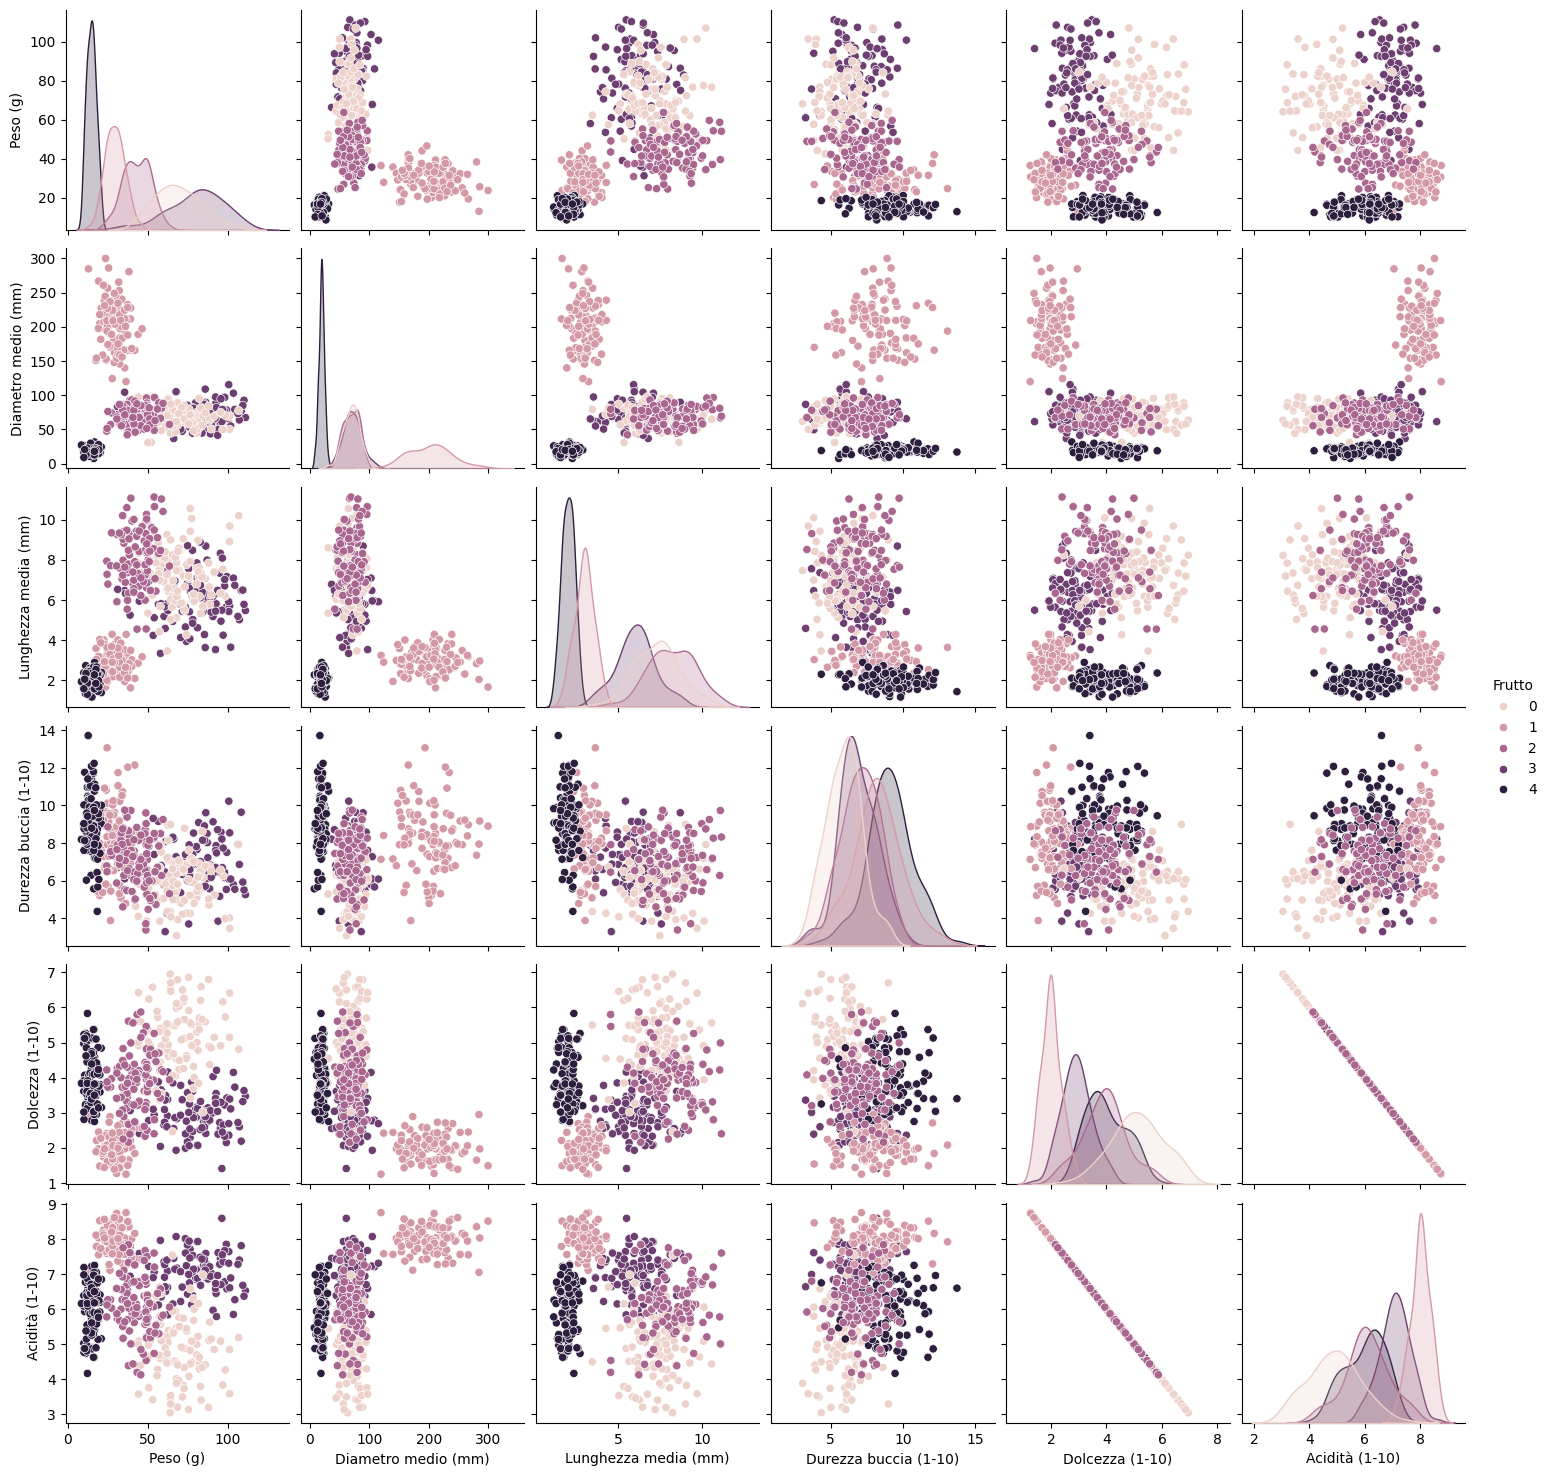

In [283]:
sns.pairplot(df, hue="Frutto")

From the pairplot above we can deduce a couple of things about the features we have to work with:


* The dataset does not have outliers. All the measurements for a given class are mainly clustered around its center
* Some fruits have overlapping characteristics
* Depending on which pair of features we look at, we can (almost) clearly distinguish one fruit from another

However, this is just a 2D plot mapping the different characteristics. On higher dimensions, it might look completely different, allowing for better separation.

In [284]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools

def plot_3d_pairplots(df, target_df):
    if len(df.columns) < 3:
        raise ValueError("The dataframe must have at least 3 features to create 3D pairplots.")

    # Get all unique combinations of three features.
    combos = list(itertools.combinations(df.columns, 3))
    n_plots = len(combos)

    # Determine grid size (roughly square)
    ncols = int(np.ceil(np.sqrt(n_plots)))
    nrows = int(np.ceil(n_plots / ncols))

    # Create a figure for the subplots
    fig = plt.figure(figsize=(5 * ncols, 5 * nrows))

    for idx, (x, y, z) in enumerate(combos):
        ax = fig.add_subplot(nrows, ncols, idx + 1, projection='3d')
        ax.scatter(df[x], df[y], df[z], c=target_df, marker='o', alpha=0.6)
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.set_zlabel(z)
        ax.set_title(f"{x}, {y}, {z}")

    plt.tight_layout()
    plt.show()

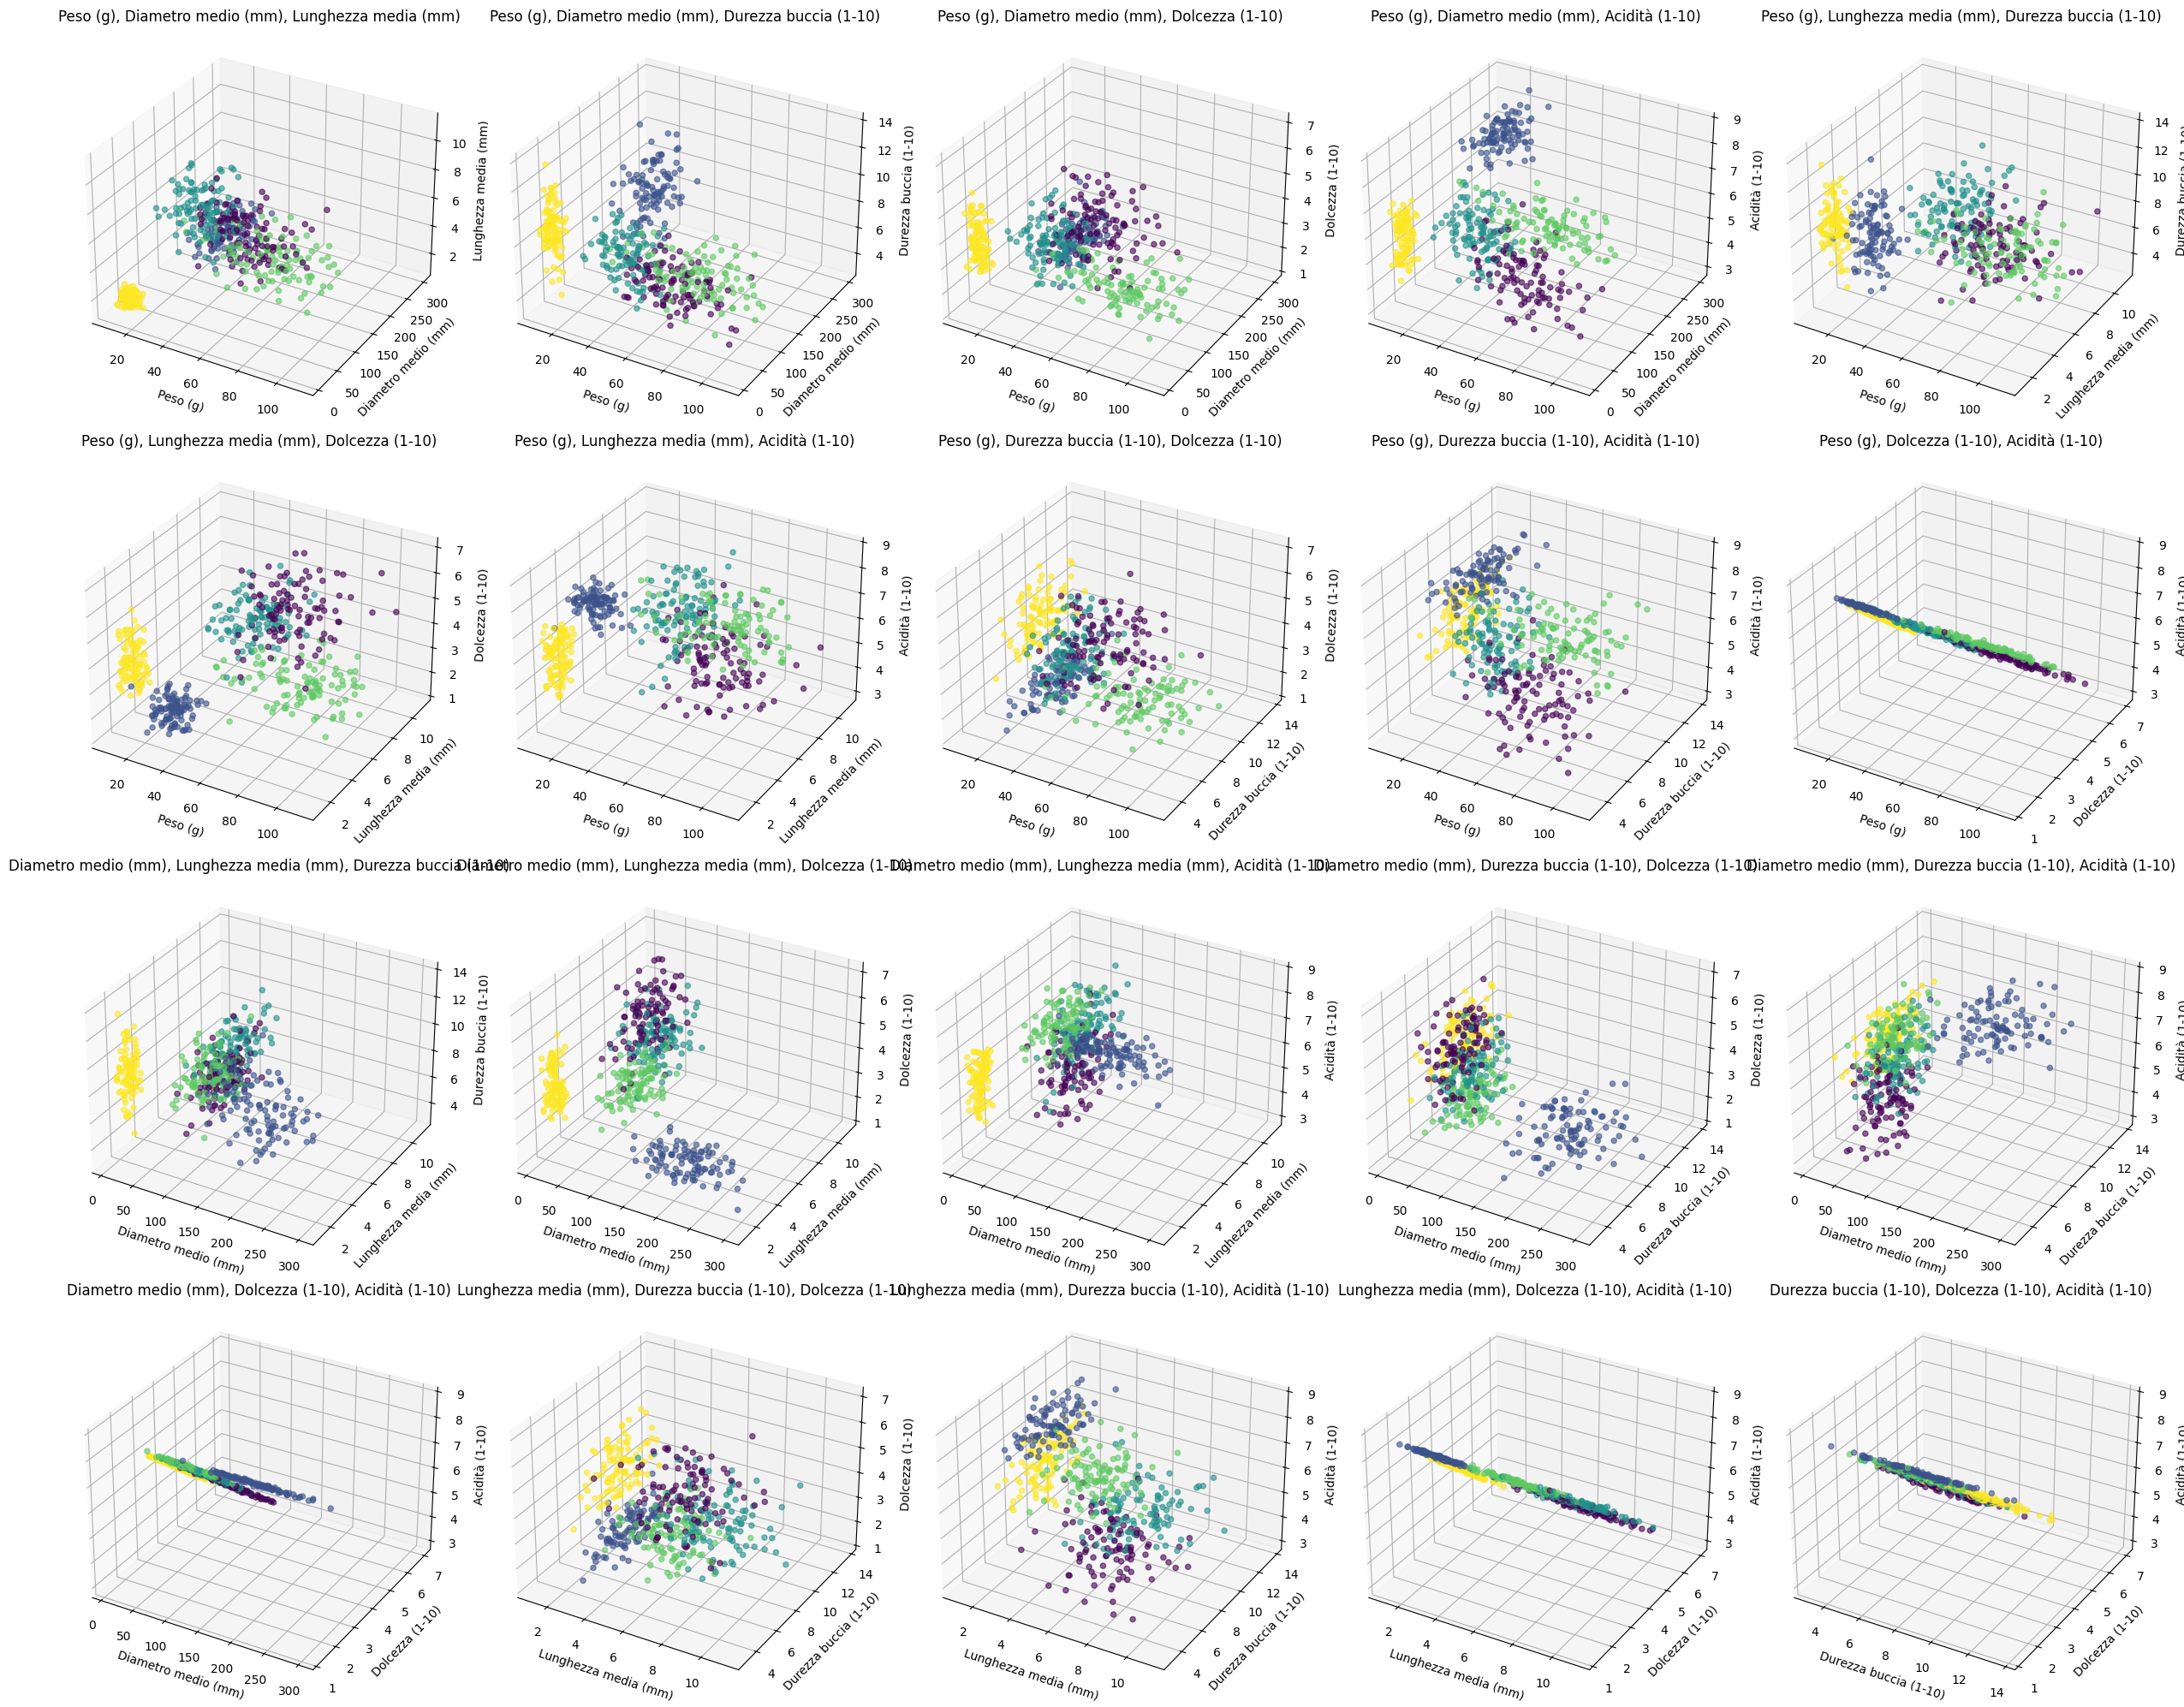

In [285]:
plot_3d_pairplots(df.drop("Frutto", axis=1), df["Frutto"])

The above pairplots are in 3 dimensions, which already allows for a clearer separation between the different features.<br>
<br>
KNN will have to work with more than 3 features, meaning that it will potentially find even better combinations at even higher dimensions.

<Axes: >

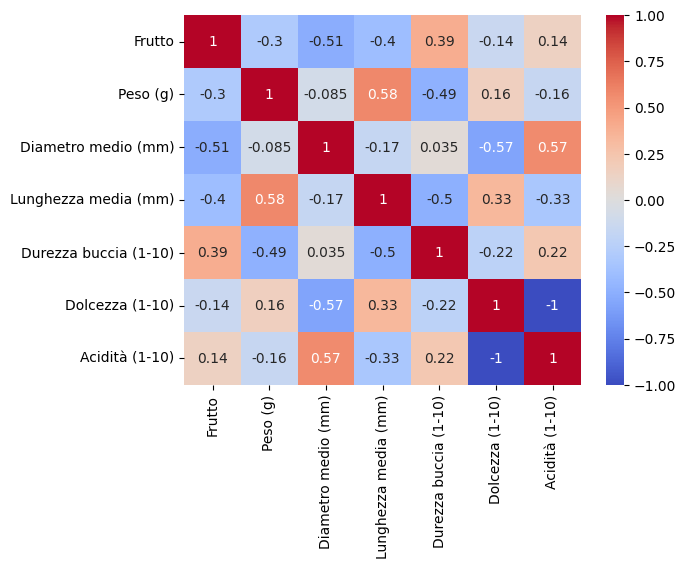

In [286]:
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

Finally, the correlation matrix, showing how each feature correlates with every other feature.<br>
From the plot above we can see how the sweetness and acidity have less impact on the outcome of our target class.<br>
Perhaps they can be combined with other features to generate new ones, or be dropped entirely.

# Preprocessing of the dataset
Before training our model, we'll need to scale the data properly. Too big values can impact the performance.

In [287]:
df.describe()

Frutto    Peso (g)  Diametro medio (mm)  Lunghezza media (mm)  \
count  500.00000  500.000000           500.000000            500.000000   
mean     2.00000   47.313440            86.573100              5.298620   
std      1.41563   26.768797            64.293403              2.641993   
min      0.00000    8.570000             7.530000              1.150000   
25%      1.00000   24.797500            50.510000              2.672500   
50%      2.00000   42.380000            70.450000              5.670000   
75%      3.00000   68.080000            88.852500              7.455000   
max      4.00000  111.210000           299.890000             11.140000   

       Durezza buccia (1-10)  Dolcezza (1-10)  Acidità (1-10)  
count             500.000000       500.000000      500.000000  
mean                7.437640         3.593220        6.406780  
std                 1.812548         1.264899        1.264899  
min                 3.070000         1.250000        3.050000  
25%                 6.152500         2.570000        5.535000  
50%                 7.340000         3.535000        6.465000  
75%                 8.615000         4.465000        7.430000  
max                13.720000         6.950000        8.750000

First thing to notice is that we have some values above their expected range, like "Durezza buccia" which is supposed to be within a range of 1 - 10. Dividing by 10 will bring it to scale, with some values reaching up to 1,372 which could still be tollerable. If it turns out to have a negative impact, we'd need to convert this scale to something different.<br>
<br>
Furthermore, "Peso" is expressed in grams with a max. of 111,21 gr. One idea could be to scale this value dividing it by 1000 (1000gr = 1Kg).<br>
<br>
"Diametro medio" and "Lunghezza media" both are expressed as millimeters, but their values are on different magnitudes. A first approach could be to scale them equally dividing by 1000 (1000mm = 100cm = 1m), but this could yield very small values and might require some testing.

# Model training
We'll first determine which number of neighbors is required to have a decent classification capability.<br>
A range of 1 to 10 will be evaluated to determine which one performs best.

In [288]:
def preprocess_data(X_train, X_test, y_train, y_test):
    range_scale_cols = [col for col in X_train.columns if "1-10" in col]
    X_train.loc[:,range_scale_cols] = X_train[range_scale_cols] / 10
    X_test.loc[:,range_scale_cols] = X_test[range_scale_cols] / 10

    cols_to_scale = [col for col in X_train.columns if "1-10" not in col]

    scaler = MinMaxScaler()
    scaler.fit(X_train[cols_to_scale])
    X_train.loc[:,cols_to_scale] = scaler.transform(X_train[cols_to_scale])
    X_test.loc[:,cols_to_scale] = scaler.transform(X_test[cols_to_scale])

    return X_train, X_test, y_train, y_test

In [289]:
def eval_kfold_model(k_neighbors, n_splits, X, y):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RNG_SEED)
    accuracy_scores = []
    rmse_scores = []
    last_model = None

    for train_index, test_index in kf.split(X.copy(), y.copy()):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        X_train_fold, X_test_fold, y_train_fold, y_test_fold = preprocess_data(X_train_fold, X_test_fold, y_train_fold, y_test_fold)

        knn = KNeighborsClassifier(n_neighbors=k_neighbors, weights="distance", metric="manhattan")
        knn.fit(X_train_fold, y_train_fold)
        y_pred = knn.predict(X_test_fold)
        #print(classification_report(y_test_fold, y_pred))

        accuracy_scores.append(accuracy_score(y_test_fold, y_pred))
        rmse_scores.append(root_mean_squared_error(y_test_fold, y_pred))

        last_model = (knn, X_train_fold, y_train_fold, X_test_fold, y_test_fold)

    print("-------------------------")
    print(f"K={k_neighbors} - Accuracy: {accuracy_scores} Mean: {np.mean(accuracy_scores):.3f}")
    print(f"K={k_neighbors} - RMSE: {np.mean(rmse_scores):.3f}")

    return last_model

In [290]:
evaluated_models = {}

for k in range(1, 11):
    evaluated_models[k] = eval_kfold_model(k, 10, df.drop("Frutto", axis=1), df["Frutto"])

-------------------------
K=1 - Accuracy: [0.96, 0.88, 0.9, 0.92, 0.96, 0.92, 0.9, 0.96, 0.88, 0.9] Mean: 0.918
K=1 - RMSE: 0.627
-------------------------
K=2 - Accuracy: [0.96, 0.88, 0.9, 0.92, 0.96, 0.92, 0.9, 0.96, 0.88, 0.9] Mean: 0.918
K=2 - RMSE: 0.627
-------------------------
K=3 - Accuracy: [0.92, 0.92, 0.92, 0.94, 0.94, 0.94, 0.9, 0.92, 0.9, 0.94] Mean: 0.924
K=3 - RMSE: 0.598
-------------------------
K=4 - Accuracy: [0.94, 0.92, 0.92, 0.94, 0.96, 0.92, 0.94, 0.92, 0.9, 0.94] Mean: 0.930
K=4 - RMSE: 0.603
-------------------------
K=5 - Accuracy: [0.9, 0.92, 0.94, 0.92, 0.96, 0.92, 0.92, 0.9, 0.86, 0.94] Mean: 0.918
K=5 - RMSE: 0.622
-------------------------
K=6 - Accuracy: [0.9, 0.9, 0.94, 0.92, 0.96, 0.92, 0.94, 0.9, 0.9, 0.94] Mean: 0.922
K=6 - RMSE: 0.622
-------------------------
K=7 - Accuracy: [0.9, 0.94, 0.96, 0.92, 0.96, 0.9, 0.94, 0.9, 0.86, 0.98] Mean: 0.926
K=7 - RMSE: 0.570
-------------------------
K=8 - Accuracy: [0.9, 0.92, 0.92, 0.92, 0.96, 0.92, 0.94, 0.8

From the accuracy scores above, K=4 seems to perform best with the given configuration.<br>
The RMSE shows the error the model causes while predicting. It's already quite low, indicating that the model is doing a good job. However, as K increases, the error also changes.<br>
A lower RMSE with a higher K-value might also indicate overfitting so it's not the only metric we should go after.<br>
Given the values above, K=3 or K=4 seem to offer the best trade-off.<br><br>
Let's evaluate the errors with K=4.

In [291]:
def plot_model_report(evaluated_models, k_value):
    knn, X_train_fold, y_train_fold, X_test_fold, y_test_fold = evaluated_models[k_value]

    y_pred = knn.predict(X_test_fold)
    y_pred_proba = knn.predict_proba(X_test_fold)
    print(classification_report(y_test_fold, y_pred))
    sns.heatmap(confusion_matrix(y_test_fold, y_pred), annot=True, xticklabels=target_classes_dict[:,1], yticklabels=target_classes_dict[:,1])

    return y_pred, y_pred_proba, X_test_fold, y_test_fold

              precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       1.00      1.00      1.00        11
           2       0.85      0.92      0.88        12
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         9

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50



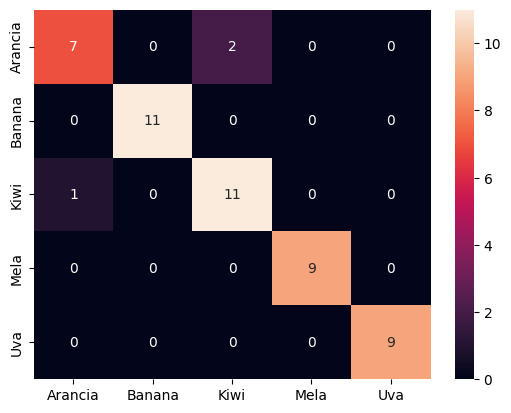

In [292]:
k_value = 4
y_pred, y_pred_proba, X_test_fold, y_test_fold = plot_model_report(evaluated_models, k_value)

The heatmap above shows that the model, in this particular test-batch, misclassified 2 samples as Kiwi instead of Oranges, and 1 sample as Orange instead of Kiwi.<br><br>
Let's try to visualize these errors on a scatterplot.

# Graphical visualization

In [293]:
def plot_knn_errors(y_pred, X_test_fold, y_test_fold):
    y_mask = (y_pred != y_test_fold)
    df_all = pd.concat([X_test_fold, y_test_fold], axis=1)

    plt.figure(figsize=(10, 6))

    for c, n in target_classes_dict:
        c = int(c)
        plt.scatter(df_all["Peso (g)"][df_all["Frutto"] == c], df_all["Lunghezza media (mm)"][df_all["Frutto"] == c], label=f"{n} ({c})")

    plt.scatter(df_all["Peso (g)"][y_mask], df_all["Lunghezza media (mm)"][y_mask], facecolors="none", edgecolors="r", s=100, marker="o", label="Error")

    plt.legend()
    plt.xlabel("Peso (g)")
    plt.ylabel("Lunghezza media (mm)")
    plt.show()

    return y_mask

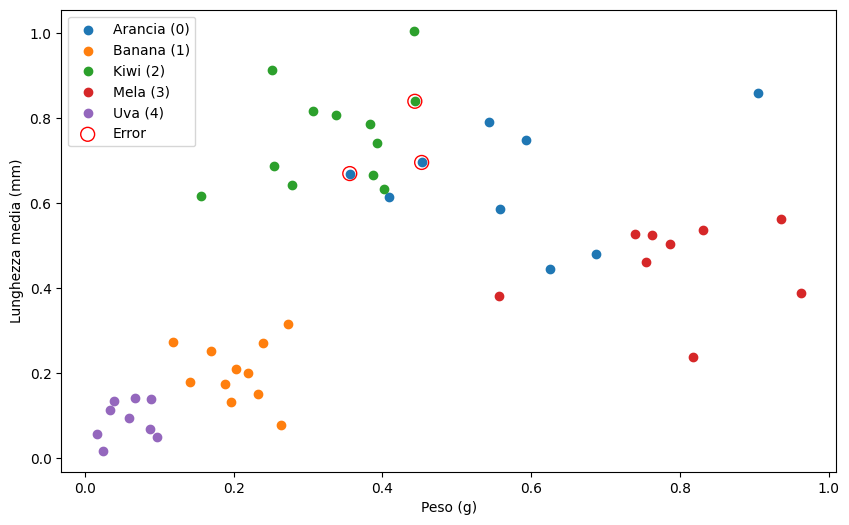

In [294]:
y_mask = plot_knn_errors(y_pred, X_test_fold, y_test_fold)

For simplicity, I plotted only a scatterplot for weight and average length which seemed to be the easiest to interpret when looking at a full pairplot.<br>
<br>
As can be seen, the KNN model misclassified the 3 highlighted samples. The 2 blue ones were supposed to be green and the green one should been blue.<br>
<br>
In this particular plot with the selected features, it would seem like all 3 should have belonged to the same class (green).
However, in a multidimensional classification problem like this one, looking only at these 2 features alone does not tell us entirely why the model associated these 3 samples to the centroids it generated.<br>
<br>
From the previous analysis, we saw that many samples had overlapping features, making it difficult to clearly distinguish one class from the other for some edge cases.<br>
<br>
Apart from those edge cases, the model is performing quite well on the dataset we've been given.

And below are the probabilities that the classifier assigned to these 3 misclassified samples:

In [295]:
df_pred_probs = pd.DataFrame(y_pred_proba[y_mask], columns=target_classes_dict[:,1])
df_pred_probs["target"] = y_test_fold[y_mask].reset_index(drop=True)
df_pred_probs["target"] = label_enc.inverse_transform(df_pred_probs["target"])
df_pred_probs.head()

Arancia  Banana      Kiwi  Mela  Uva   target
0  0.225990     0.0  0.774010   0.0  0.0  Arancia
1  0.000000     0.0  1.000000   0.0  0.0  Arancia
2  0.759635     0.0  0.240365   0.0  0.0     Kiwi

# Feature engineering with domain expertise
One way to improve the model <u><b>might</b></u> be by introducing additional domain-specific features, like texture, color, etc and not just measurements.

In [296]:
target_classes_dict

array([['0', 'Arancia'],
       ['1', 'Banana'],
       ['2', 'Kiwi'],
       ['3', 'Mela'],
       ['4', 'Uva']], dtype='<U21')

In [297]:
df2 = df.copy()

df2.loc[df2["Frutto"] == 0, "texture"] = "rugosa"
df2.loc[df2["Frutto"] == 1, "texture"] = "liscia"
df2.loc[df2["Frutto"] == 2, "texture"] = "pelosa"
df2.loc[df2["Frutto"] == 3, "texture"] = "liscia"
df2.loc[df2["Frutto"] == 4, "texture"] = "liscia"

# Commented out, yields the same results as with texture alone
#df2.loc[df2["Frutto"] == 0, "color"] = "arancione"
#df2.loc[df2["Frutto"] == 1, "color"] = "giallo"
#df2.loc[df2["Frutto"] == 2, "color"] = "marrone"
#df2.loc[df2["Frutto"] == 3, "color"] = "verde"
#df2.loc[df2["Frutto"] == 4, "color"] = "verde chiaro"

label_enc2 = LabelEncoder()
df2["texture"] = label_enc2.fit_transform(df2["texture"])

#label_enc3 = LabelEncoder()
#df2["color"] = label_enc3.fit_transform(df2["color"])

# Cast column to float type otherwise the scaler will complain
df2["texture"] = df2["texture"].astype(float)
#df2["color"] = df2["color"].astype(float)

print(df2["texture"].unique())
#print(df2["color"].unique())

[0. 2. 1.]


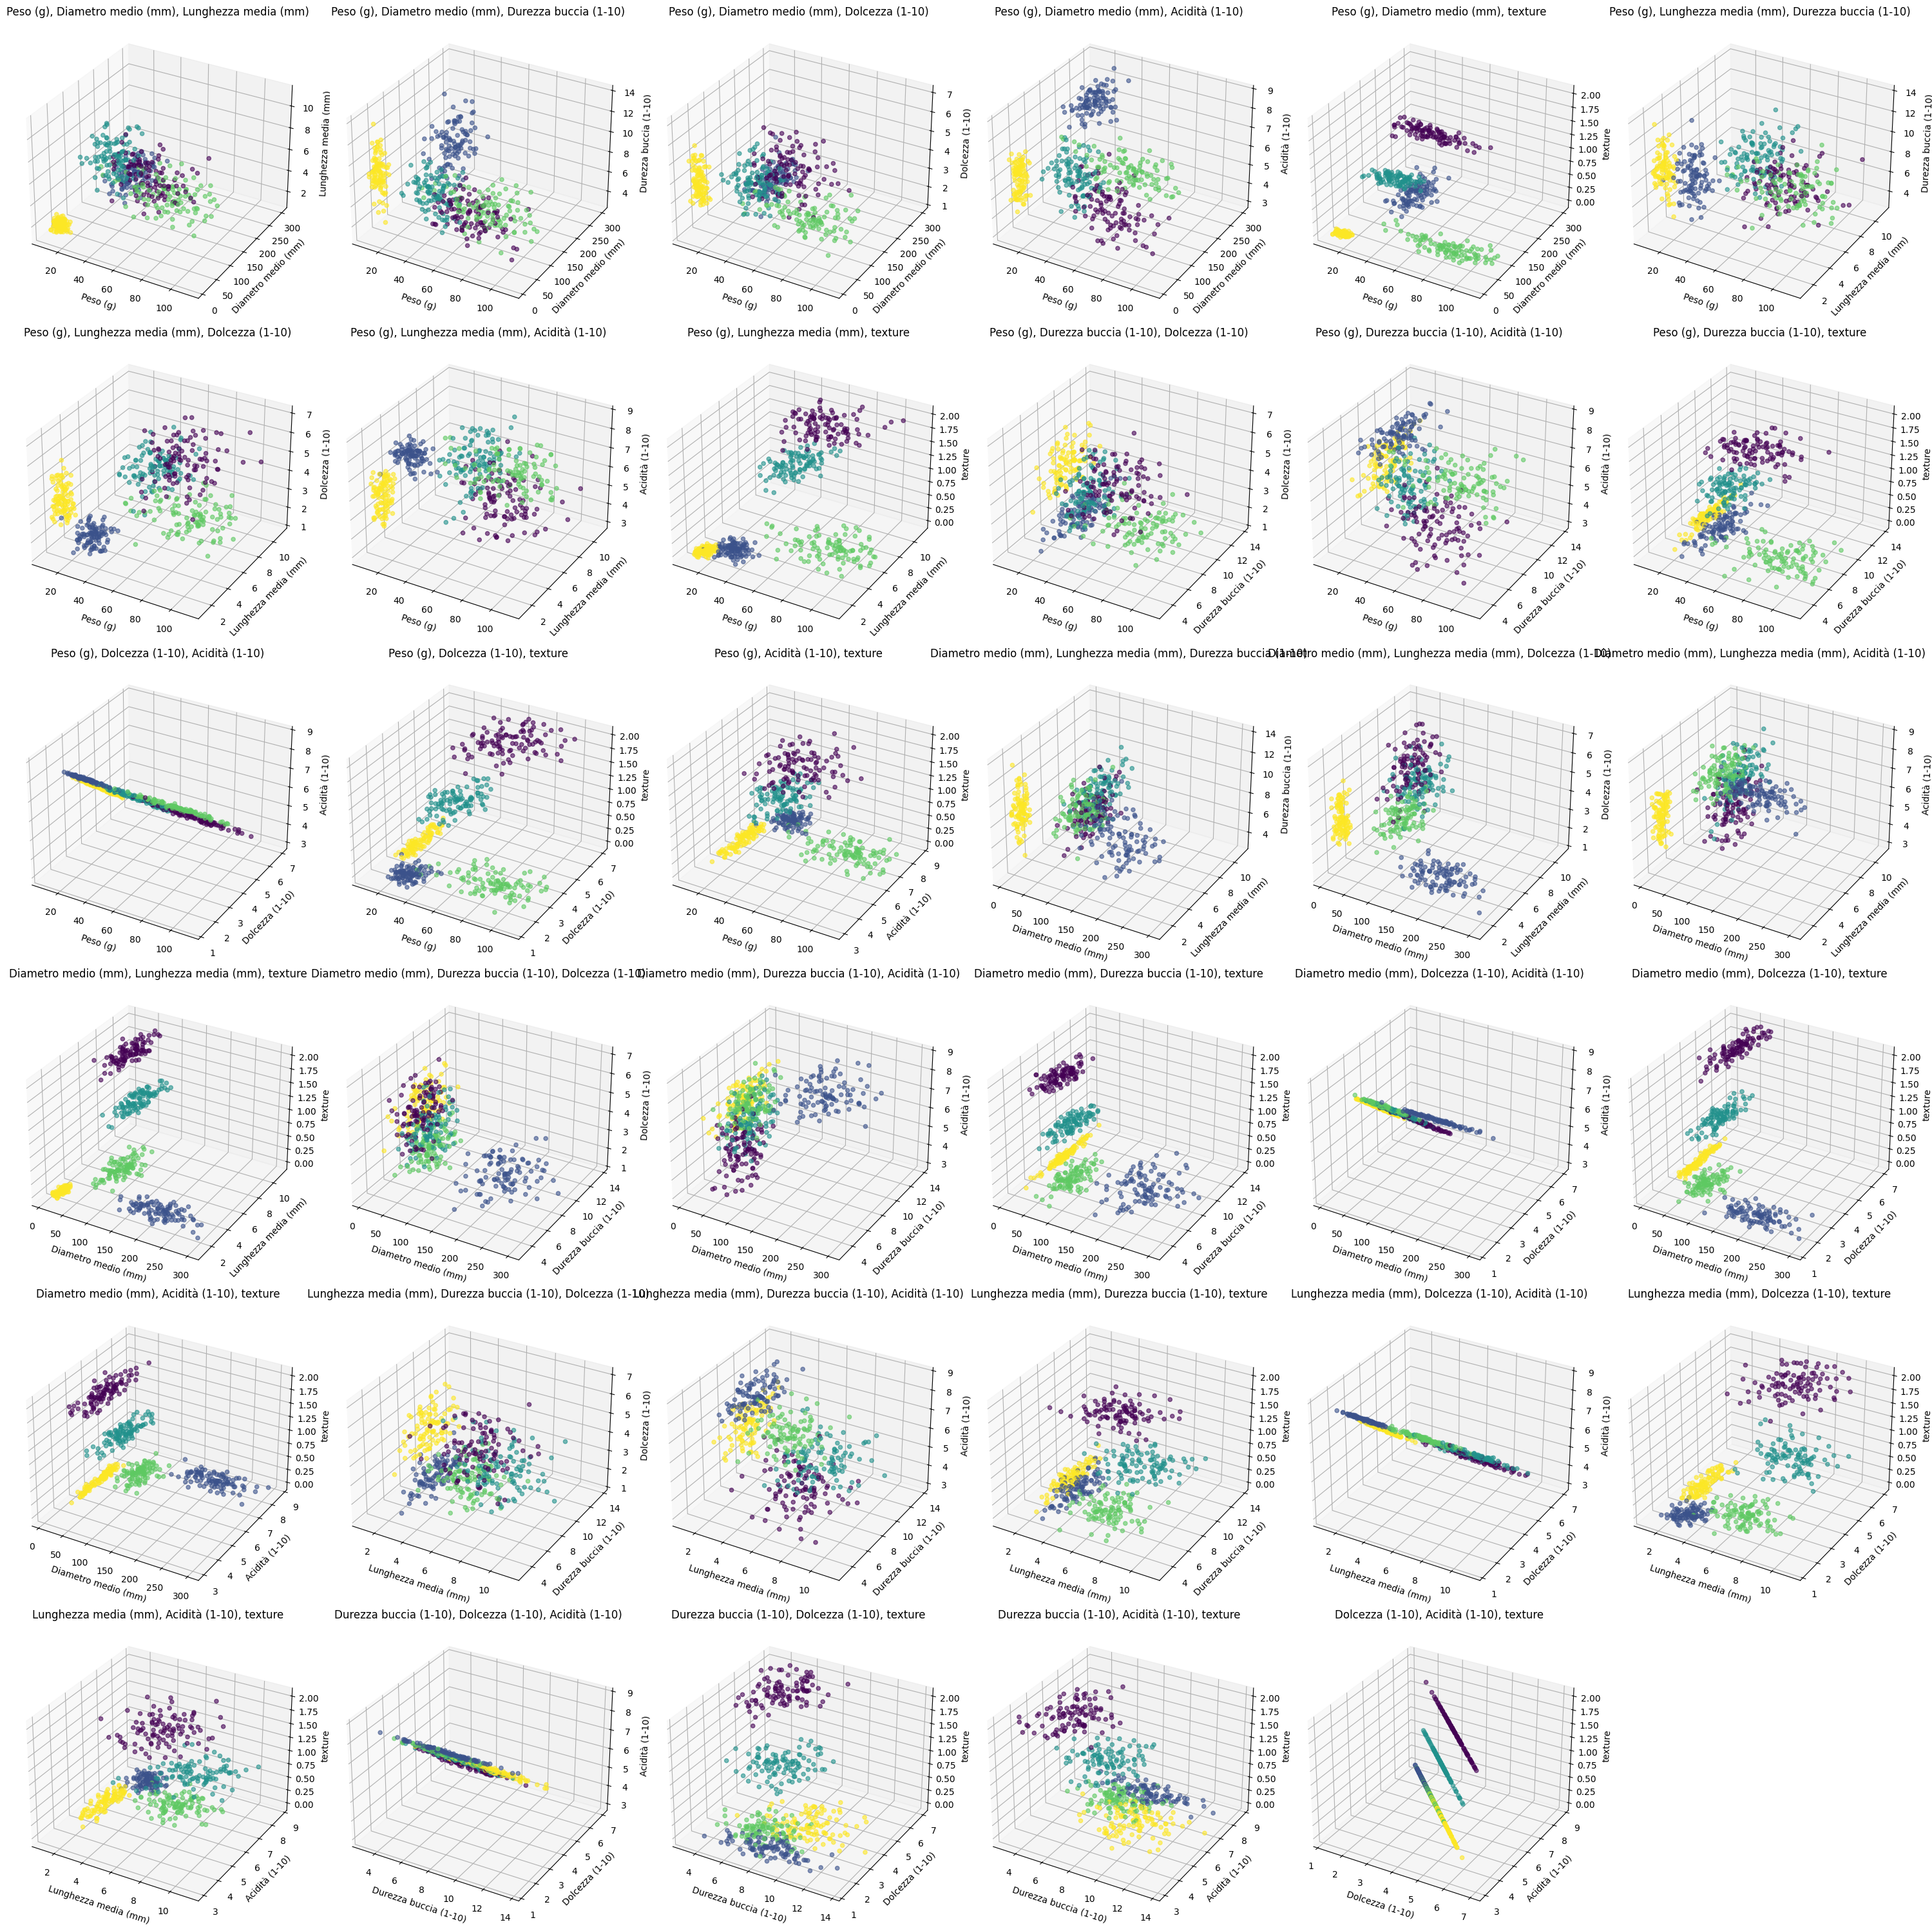

In [298]:
plot_3d_pairplots(df2.drop("Frutto", axis=1), df2["Frutto"])

As can be seen in the 3D pair plots above, all combinations where our new features are used clearly separate the different categories.

In [299]:
evaluated_models2 = {}

for k in range(1, 11):
    evaluated_models2[k] = eval_kfold_model(k, 10, df2.drop("Frutto", axis=1), df2["Frutto"])

-------------------------
K=1 - Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] Mean: 1.000
K=1 - RMSE: 0.000
-------------------------
K=2 - Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] Mean: 1.000
K=2 - RMSE: 0.000
-------------------------
K=3 - Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] Mean: 1.000
K=3 - RMSE: 0.000
-------------------------
K=4 - Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] Mean: 1.000
K=4 - RMSE: 0.000
-------------------------
K=5 - Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] Mean: 1.000
K=5 - RMSE: 0.000
-------------------------
K=6 - Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] Mean: 1.000
K=6 - RMSE: 0.000
-------------------------
K=7 - Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] Mean: 1.000
K=7 - RMSE: 0.000
-------------------------
K=8 - Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] Mean: 1.000
K=8 - RMSE: 0.000
----------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         9

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



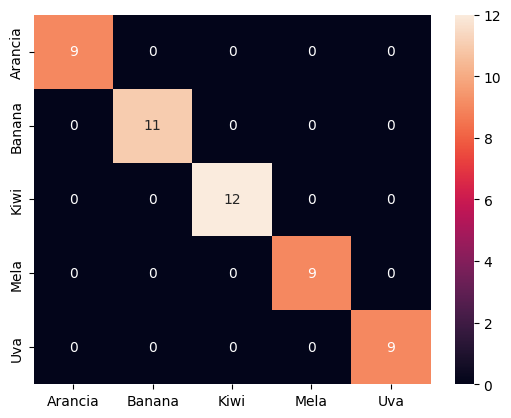

In [300]:
k_value = 4
y_pred, y_pred_proba, X_test_fold, y_test_fold = plot_model_report(evaluated_models2, k_value)

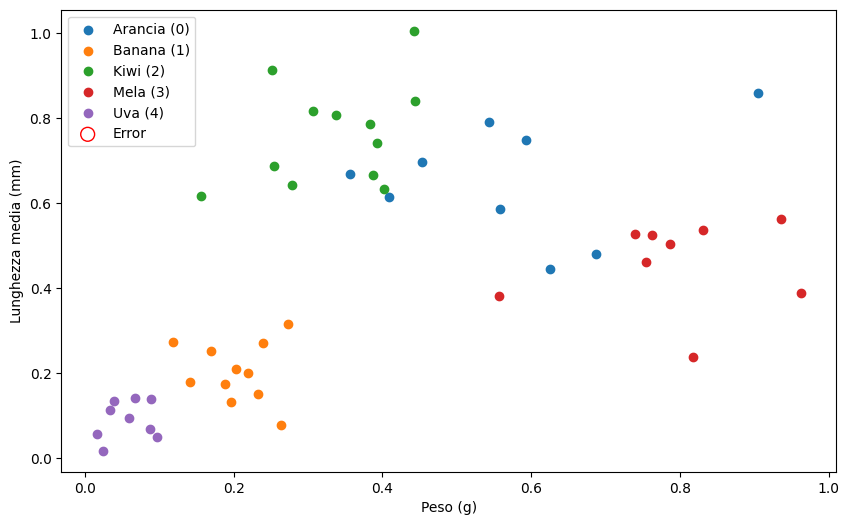

In [301]:
_ = plot_knn_errors(y_pred, X_test_fold, y_test_fold)

As expected, adding visual features made the classifier reach 100% accuracy with little to no effort.<br>
<br>
Let's try one additional approach given the data we had in the original dataset.<br>

In [302]:
df3 = df.copy()

#df3["nice_to_eat"] = 0.0
#df3.loc[
#    (df3["Dolcezza (1-10)"] >= 5.0) | (df3["Durezza buccia (1-10)"] <= 6.5),
#    "nice_to_eat"
#] = 1.0
#print(df3["nice_to_eat"].value_counts())

df3["density"] = df3["Peso (g)"] / (df3["Diametro medio (mm)"] * df3["Lunghezza media (mm)"])
#df3["flavor"] = df3["Dolcezza (1-10)"] / df3["Acidità (1-10)"]
#df3["aspect"] = df3["Diametro medio (mm)"] / df3["Lunghezza media (mm)"]

#df3 = df3.drop(["Diametro medio (mm)", "Lunghezza media (mm)"], axis=1)

df3

Frutto  Peso (g)  Diametro medio (mm)  Lunghezza media (mm)  \
0         3     86.40                89.68                  8.69   
1         3     77.58                73.45                  6.49   
2         3     81.95                81.66                  6.40   
3         3     66.33                36.71                  6.78   
4         3     56.73                75.69                  5.78   
..      ...       ...                  ...                   ...   
495       2     40.82                67.52                  7.39   
496       2     54.65                62.95                  7.06   
497       2     35.70                71.43                  7.64   
498       2     30.80                65.23                  5.91   
499       2     63.71                57.30                  7.69   

     Durezza buccia (1-10)  Dolcezza (1-10)  Acidità (1-10)   density  
0                     9.61             2.41            7.59  0.110866  
1                     7.20             3.87            6.13  0.162747  
2                     9.09             2.88            7.12  0.156805  
3                     8.21             2.55            7.45  0.266499  
4                     9.15             3.88            6.12  0.129672  
..                     ...              ...             ...       ...  
495                   7.28             5.56            4.44  0.081808  
496                   6.47             4.68            5.32  0.122967  
497                   9.75             4.36            5.64  0.065418  
498                   7.65             4.13            5.87  0.079894  
499                   5.30             3.94            6.06  0.144586  

[500 rows x 8 columns]

<Axes: >

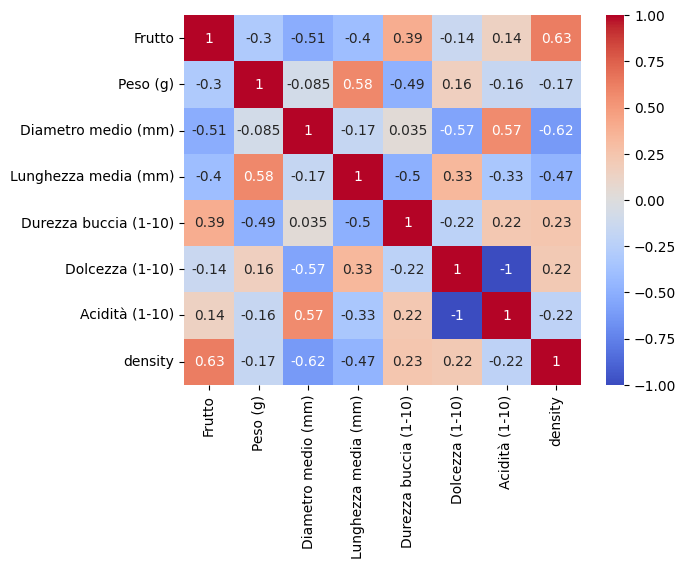

In [303]:
sns.heatmap(df3.corr(), annot=True, cmap="coolwarm")

In [304]:
evaluated_models3 = {}

for k in range(1, 11):
    evaluated_models3[k] = eval_kfold_model(k, 10, df3.drop("Frutto", axis=1), df3["Frutto"])

-------------------------
K=1 - Accuracy: [0.96, 0.9, 0.92, 0.92, 0.96, 0.92, 0.9, 0.94, 0.9, 0.92] Mean: 0.924
K=1 - RMSE: 0.616
-------------------------
K=2 - Accuracy: [0.96, 0.9, 0.92, 0.92, 0.96, 0.92, 0.9, 0.94, 0.9, 0.92] Mean: 0.924
K=2 - RMSE: 0.616
-------------------------
K=3 - Accuracy: [0.94, 0.92, 0.94, 0.94, 0.94, 0.92, 0.9, 0.92, 0.88, 0.94] Mean: 0.924
K=3 - RMSE: 0.626
-------------------------
K=4 - Accuracy: [0.94, 0.9, 0.94, 0.94, 0.96, 0.92, 0.96, 0.92, 0.88, 0.94] Mean: 0.930
K=4 - RMSE: 0.607
-------------------------
K=5 - Accuracy: [0.88, 0.94, 0.92, 0.92, 0.96, 0.9, 0.94, 0.9, 0.86, 0.92] Mean: 0.914
K=5 - RMSE: 0.636
-------------------------
K=6 - Accuracy: [0.9, 0.94, 0.96, 0.92, 0.96, 0.92, 0.96, 0.92, 0.92, 0.94] Mean: 0.934
K=6 - RMSE: 0.567
-------------------------
K=7 - Accuracy: [0.86, 0.94, 0.94, 0.9, 0.96, 0.9, 0.96, 0.9, 0.88, 0.96] Mean: 0.920
K=7 - RMSE: 0.600
-------------------------
K=8 - Accuracy: [0.86, 0.92, 0.94, 0.92, 0.96, 0.92, 0.96

The only additional feature that yielded a slightly better mean score is the fruit density, giving a mean of 0.934 for K=6 compared to 0.93 for K=4 and a lower RMSE.
<br>
Let's see the errors we get with K=6.

              precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       1.00      1.00      1.00        11
           2       0.85      0.92      0.88        12
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         9

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50



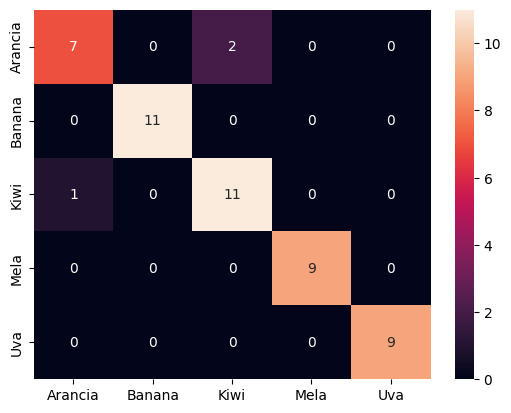

In [305]:
k_value = 6
y_pred, y_pred_proba, X_test_fold, y_test_fold = plot_model_report(evaluated_models3, k_value)

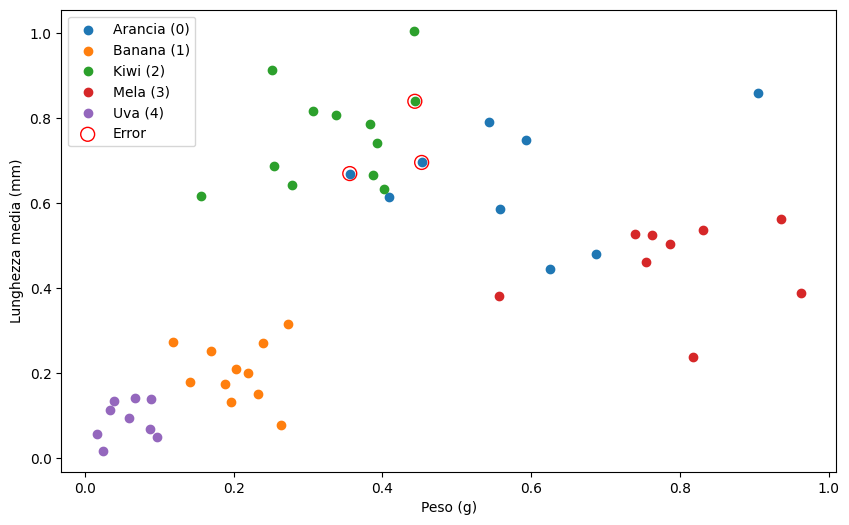

In [306]:
_ = plot_knn_errors(y_pred, X_test_fold, y_test_fold)

Overall this additional feature made no difference. The misclassified samples are still the same as in the first model.

# Conclusion

The problem was about correctly classifying fruits through different measurements such as weight, diameter, length, sweetness, etc.<br>
KNN manages to do a very good job at distinguishing them, reaching an accuracy of up to 0.93 given that there are many samples with overlapping characteristics.<br>
<br>
Extending the information provided by the dataset (e.g. by including more visual characteristics such as color and textures) could further improve the performance of the model, as proven by our experiment.<br>
<br>
On the other hand, generating new features with the ones provided by the dataset did not lead to improved performance.